<a href="https://colab.research.google.com/github/cincinnatilibrary/collection-analysis/blob/master/misc/loan_rules_visualized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHPL - Collection Analysis - **Loan Rules Visualized (2022-04-12)**
<img src="https://ilsweb.cincinnatilibrary.org/img/CHPL_Brandmark_Primary.png" alt="CHPL" title="CHPL" width="300"/>

## Purpose:

This notebook aims to present topics around Circulation Loan Rules in the effort to gain a better understanding of attributes used by the Loan Rule Determiner Table, and how Loan Rules are applied in certain circumstances.

## Data Used:

This notebook uses several sets of data from the Sierra ILS:

* `Loan Rules` & `Loan Rule Determiner` Data:

   Loan Rules, and the Loan Rule Determiner can be exported from Sierra in the following method from the SDA:
`Admin` -> `Parameters` -> `Circulation` -> (`Loan Rule Determiner`, `Loan Rules`):
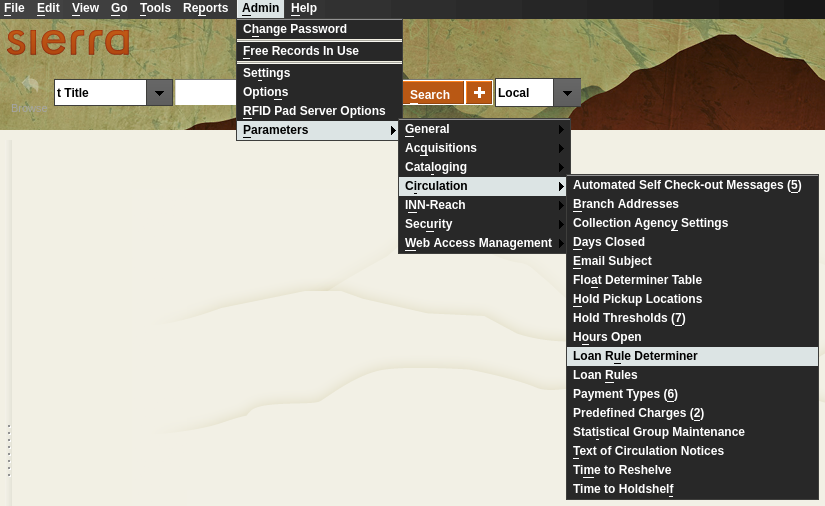
* Seirra SQL Query / Aggregated Checkout Data:
  
  By aggregating the previous 6 months worth of circulation transactions from Sierra's `circ_trans` table, we can determine how Loan Rules are being applied in the system as they've been configured.




### How Sierra Determines the Loan Rule for a Transaction

https://documentation.iii.com/sierrahelp/Default.htm#sgcir/sgcir_ckout_loanrule.html

---

#### The system applies a loan rule when you perform the following types of circulation transactions:

* checking out an item
* placing a hold
* placing a held item on the holdshelf
* renewing an item, if the Renewals: Check loan rule at time of renewal circulation option is set to "YES"

---

#### To select a loan rule for a transaction, the system does the following:

1. Determines the transaction location.
  * If the Loan Rule Determined by Login Location feature is enabled, the system uses the checkout location as the transaction location.
  * If you are filling a hold and the Holdshelf Loan Rule Set by Pickup Location feature is enabled, the system uses the pickup location as the transaction location.
  * Otherwise, the system uses the LOCATION fixed-length field in the item record as the transaction location.
1. Finds the relevant entry in the Loan Rule Determiner table. To do so, the system searches the Loan Rule Determiner table from bottom to top until it finds an active entry that meets the following criteria:
  * The Location element includes the transaction location.
  * The Item Type element includes the item's I TYPE.
  * The Patron Type element matches the patron's P TYPE.
  * The value in the patron's BIRTH DATE field falls within the range specified in the Age Range element.
  * The entry is active.
1.Applies the loan rule indicated in the Rule Number element of the Loan Rule Determiner entry.

#### Note

* Table Read Bottom to Top
  
  **The system reads the Loan Rule Determiner table from bottom to top**. General entries (such as those that contain wildcards) should appear higher in the table than more specific entries.

* **First Entry Should Point to Non-circulating Loan Rule**
  The very first entry in the table should be set up to apply to all locations, P TYPEs, I TYPEs, and age ranges 
  That is:
    * Location is "?????"
    * Patron Type is "9999"
    * Item Type is "9999"
    * Age Range is blank
  
  and should refer to a non-circulating loan rule. **Thus, if no entries in the table apply to the particular combination of location, P TYPE, I TYPE, and age range, the system will advise the operator that the item is non-circulating.** 
  
---

Entries in the Loan Rule Determiner table contain the following data elements:

https://documentation.iii.com/sierrahelp/Default.htm#sril/sril_circ_param_lr_dtr.html

* Location
* Patron Type
* Item Type
* ~Age Range~ N/A (e.g. is blank)
* Rule Number
* Active
* Editable By

--- 

Loan Rules

https://documentation.iii.com/sierrahelp/Default.htm#sril/sril_circ_param_lr.html

In [3]:
import pandas as pd
import altair as alt
from sqlalchemy import create_engine

# download loan rule related files for processing ... 
# (you can also just skip this step, reproduce them manually--as described above--and place them manually in this notebook directory)
#
# loanruledeterminer.csv
!wget --quiet https://raw.githubusercontent.com/cincinnatilibrary/collection-analysis/78a8d50091d3486a14c84969631ad4a3b802e879/misc/loanruledeterminer_202204120828.csv --output-document=loanruledeterminer.csv > /dev/null

# loanrules.csv
!wget --quiet https://raw.githubusercontent.com/cincinnatilibrary/collection-analysis/78a8d50091d3486a14c84969631ad4a3b802e879/misc/loanrules_202204120828.csv --output-document=loanrules.csv > /dev/null

# loanrule_agg_circ_data.csv
!wget --quiet https://raw.githubusercontent.com/cincinnatilibrary/collection-analysis/ca5444950e6e1987348b188e48503e5d909b1261/misc/loanrule_agg_circ_data_202204120828.csv --output-document=loanrule_agg_circ_data > /dev/null

# create dataframes
#
loanruledeterminer_df = pd.read_csv('/content/loanruledeterminer.csv')
# rename the column `Unnamed: 0` to what it actually is ... `loanrule_code_num`
loanruledeterminer_df = loanruledeterminer_df.rename(columns={'Rule Number': 'loanrule_code_num'})

loanrules_df = pd.read_csv('/content/loanrules.csv')

loanrule_agg_circ_data_df = pd.read_csv('/content/loanrule_agg_circ_data')

# create sqlite db
engine = create_engine('sqlite:///loanrule.db')

# build the sqlite db from the dataframes ...
loanrule_agg_circ_data_df.to_sql('loanrule_agg_circ_data', con=engine, if_exists='replace')
loanruledeterminer_df.to_sql('loanruledeterminer', con=engine, if_exists='replace')
loanrules_df.to_sql('loanrules', con=engine, if_exists='replace')

In [ ]:
# explore the determiner table ...
%load_ext google.colab.data_table
loanruledeterminer_df

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Unnamed: 0,Location,Patron Type,Item Type,Age Range,loanrule_code_num,Active,Editable By
0,1,?????,9999,9999,NaN,1,Y,ALL
1,2,?????,12,9999,NaN,12,Y,ADMIN
2,3,?????,"0,22,32,196",231,NaN,50,N,ADMIN
3,4,?????,"0,22,32,196",231,NaN,33,Y,ADMIN
4,5,?????,"0,22,32,196",208,NaN,50,N,ADMIN
...,...,...,...,...,...,...,...,...
176,177,2xatd,9999,113,NaN,1,Y,ADMIN
177,178,2xatd,"0,5,6,10,22,30,31,32,196",113,NaN,48,Y,ADMIN
178,179,?????,199,9999,NaN,30,Y,ALL
179,180,?????,"200-205,210,212-217,220-223","0,2,4,15,20,22,24,60-61,65-66,70-72,77-78,134,...",NaN,34,Y,ADMIN


In [9]:
# explore the loanrule_agg_circ_data table ...
%load_ext google.colab.data_table
loanrule_agg_circ_data_df

,itype_code_num,item_format,ptype_code,patron_type,loanrule_code_num,count_transactions,min_trans_date,max_trans_date
0,0,Book,0,Unlimited,7,471143,2021-10-13,2022-04-11
1,0,Book,1,Child Only (7 Items),4,45,2021-10-26,2022-03-28
2,0,Book,10,Educator,11,7337,2021-10-13,2022-04-11
3,0,Book,12,Outreach-NO Rating Sheet,12,15754,2021-10-14,2022-04-12
4,0,Book,15,Bookclub,43,6301,2021-10-13,2022-04-11
...,...,...,...,...,...,...,...,...
409,230,OHPIR Requestable,22,Honorary,32,10,2021-11-12,2022-02-23
410,230,OHPIR Requestable,32,Non-Resident Unlimited,32,6,2021-10-27,2022-03-11
411,231,OHPIR Requestable Movie,0,Unlimited,33,5904,2021-10-13,2022-04-11
412,231,OHPIR Requestable Movie,22,Honorary,33,13,2021-11-01,2022-03-25


In [ ]:
loanrules_df.columns

Index(['Unnamed: 0', 'Name', 'Code', 'Normal Loan Period', 'Holdable',
       'Bookable', 'Home Pickup', 'Shippable', 'Ship Time',
       'Time Remaining B4 Renew', 'First Renewal Period',
       'Additional Renewal Period', 'Max Number Of Renewals',
       'Max Number Of Auto Renewals', 'Minimum Use', 'Eligib To Recall',
       'Time Return Recall', 'Time To Pickup', 'Max Number Of Odues',
       'Time First Odue', 'Time Second Odue', 'Time Third Odue',
       'Time Fourth Odue', 'Time Fifth Odue', 'Time Sixth Odue',
       'Text First Odue', 'Text Second Odue', 'Text Third Odue',
       'Text Fourth Odue', 'Text Fifth Odue', 'Odue Penalty',
       'Text First OdueR', 'Text Second OdueR', 'Text Third OdueR',
       'Text Fourth OdueR', 'Text Fifth OdueR', 'Courtesy Notice Text Number',
       'Number Of Days Before Odue', 'Time 1ST Odue Recall',
       'Text Recall Notice', 'Text Pickup Notice', 'Text Cancel Pickup',
       'Grace Period For Fines', 'Number Of D/HR 1st F Per',
       

In [ ]:
# this query will aggregate previous 6 months worth of circulation transactions 
# to examine ptype, and itype counts by loan rule
# (run this query and import the .csv below)

sql = """\
WITH agg_circ_data AS (
	SELECT 
	itype_code_num, -- item_format
	ptype_code,
	loanrule_code_num,
	count(*) AS count_transactions,
	date(min(transaction_gmt)) AS min_trans_date,
	date(max(transaction_gmt)) AS max_trans_date
	FROM 
	sierra_view.circ_trans AS c
	WHERE
	c.op_code = 'o' -- checkouts
	AND c.transaction_gmt >= date('now') - '6 months' :: INTERVAL -- circ_tras 6 or more months old
	GROUP BY 1,2,3
)
SELECT
itype_code_num,
(
	SELECT 
	ipn."name"
	FROM 
	sierra_view.itype_property AS ip  
	JOIN sierra_view.itype_property_name AS ipn ON ipn.itype_property_id = ip.id
	WHERE
	ip.code_num = d.itype_code_num
	LIMIT 1
) AS item_format,
ptype_code,
(
	SELECT 
	ppn.description 
	FROM
	sierra_view.ptype_property AS pp 
	JOIN sierra_view.ptype_property_name AS ppn ON ppn.ptype_id = pp.id
	WHERE
	pp.value = d.ptype_code :: integer
	LIMIT 1
) AS patron_type,
loanrule_code_num,
count_transactions,
min_trans_date,
max_trans_date
FROM 
agg_circ_data AS d
"""

df = pd.read_csv('/content/agg_circ_data_202204120828.csv')



### data sample:

In [ ]:
df.head()

,itype_code_num,item_format,ptype_code,patron_type,loanrule_code_num,count_transactions,min_trans_date,max_trans_date
0,0,Book,0,Unlimited,7,471143,2021-10-13,2022-04-11
1,0,Book,1,Child Only (7 Items),4,45,2021-10-26,2022-03-28
2,0,Book,10,Educator,11,7337,2021-10-13,2022-04-11
3,0,Book,12,Outreach-NO Rating Sheet,12,15754,2021-10-14,2022-04-12
4,0,Book,15,Bookclub,43,6301,2021-10-13,2022-04-11


### Checkout Transactins by Loan Rule:

(the output .csv is availbale to download after running the cell below)

In [ ]:
# generate .csv output for this total transactions by loanrule
df.groupby(['loanrule_code_num'])['count_transactions'].sum().reset_index().to_csv('total_transactions_by_loanrule.csv')

alt.Chart(df.groupby(['loanrule_code_num'])['count_transactions'].sum().reset_index()).mark_bar(color='#34B78F').encode(
    x=alt.X(
        'loanrule_code_num:O',
        axis=alt.Axis(title='Loan Rule', labelAngle=-70),
        sort='-y'
    ),
    y=alt.Y(
        'count_transactions',
        axis=alt.Axis(title='Count Checkout Transactions')
    ),
    tooltip=['loanrule_code_num', 'count_transactions']
)



alt.Chart(...)

### Facet By Loan Rule Number:

In [ ]:
alt.Chart(df).mark_bar().encode(
    x=alt.X(
        'patron_type',
        axis=alt.Axis(title='Patron Type', labelAngle=-70)
    ),
    y=alt.Y(
        'count_transactions',
        axis=alt.Axis(title='Count Transactions')
    ),
    color=alt.Color(
        'item_format',
        legend=alt.Legend(
            columns=2, symbolLimit=0
        )
        # axis=alt.Axis(
        #     title='Item Format',
        #     # labelLimit=None
        # )
    ),
    tooltip=['itype_code_num', 'item_format', 'ptype_code', 'patron_type', 'loanrule_code_num', 'count_transactions', 'min_trans_date', 'max_trans_date']
).facet(
    'loanrule_code_num'
)

alt.FacetChart(...)